In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.misc import imshow

import sys
sys.path.insert(0, '../../LEARNING/tensorflow')
sys.path.insert(0, '../../LEARNING/PCA_dl')
from layers import full_connected
from Dataset import DatasetNoLabel

In [4]:
data = pd.read_csv('./inputs/train.csv').values[:, 1:].reshape(-1, 28, 28, 1)

In [27]:
class DatasetNoLabel(object):
    def __init__(self, data):
        self._data = data
        self._num_examples = data.shape[0]
        self._epochs_completed = 0
        self._index_in_epoch = 0
    @property
    def data(self):
        return self._data
    @property
    def num_examples(self):
        return self._num_examples
    @property
    def epochs_completed(self):
        return self._epochs_completed
    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._data = self._data[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._data[start:end]

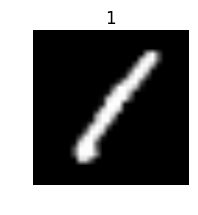

In [57]:
def showimg(imgdata, title=None, figsize=(2, 2), shape=(28, 28)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(imgdata.reshape(shape))
    plt.gray()
    plt.axis('off')
    if title != None:
        plt.title(title)

# test
showimg(data[0], 1)

In [42]:
def weight_variable(shape, name=None):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)

def bias_variable(shape, name=None):
    return tf.Variable(tf.constant(0.1, shape = shape), name)

def create_FC_variables(layer_dim):
    Ws = []
    bs = []
    token = np.random.randint(1)
    for i in range(0, len(layer_dim)-1):
        w = weight_variable([layer_dim[i], layer_dim[i+1]], 'w'+str(token)+str(i))
        b = bias_variable([layer_dim[i+1]], 'b'+str(token)+str(i))
        
        tf.add_to_collection('vars', w)
        tf.add_to_collection('vars', b)
        Ws.append(w)
        bs.append(b)
    return Ws, bs
    
def activate(prev_layer, weight, bias, activation=None):
    linear_combination = tf.matmul(prev_layer, weight) + bias
    
    if activation == None:
        return linear_combination
    if activation == 'relu':
        return tf.nn.relu(linear_combination)
    if activation == 'sigmoid':
        return tf.nn.sigmoid(linear_combination)
    if activation == 'tanh':
        return tf.nn.tanh(linear_combination)

In [43]:
def encoder(origin, Ws, bs):
    layer = origin
    
    for i in range(len(Ws)):
        layer = activate(layer, Ws[i], bs[i], activation='sigmoid')
        
    encoded = layer
    return encoded

def decoder(encoded, Ws, bs):
    layer = encoded
    
    for i in range(len(Ws)-1):
        layer = activate(layer, Ws[i], bs[i], activation='sigmoid')
    layer = activate(layer, Ws[-1], bs[-1])
    
    decoded = layer
    return decoded

In [6]:
x = tf.placeholder(tf.float32, shape=(None, 28*28))

#eWs, ebs = create_FC_variables([784, 300, 100,  20])
#dWs, dbs = create_FC_variables([ 20, 100, 300, 784])

#ED = encoder(x, eWs, ebs)
#DD = decoder(ED, dWs, dbs)

el1 = full_connected(x  , 300, 'el1', 'sigmoid')
el2 = full_connected(el1, 100, 'el2', 'sigmoid')
el3 = full_connected(el2,  75, 'el3', 'sigmoid')
el4 = full_connected(el3,  50, 'el4', 'sigmoid')
ED  = full_connected(el4,  20, 'ed' , 'sigmoid')

dl1 = full_connected(ED,   50, 'dl1', 'sigmoid')
dl2 = full_connected(dl1,  75, 'dl2', 'sigmoid')
dl3 = full_connected(dl2, 100, 'dl3', 'sigmoid')
dl4 = full_connected(dl3, 300, 'dl4', 'sigmoid')
DD  = full_connected(dl4, 784, 'dd')

In [46]:
loss = tf.reduce_mean(tf.pow(DD - x, 2))
optimizer = tf.train.RMSPropOptimizer(0.01).minimize(loss)

dataset = DatasetNoLabel(data)

saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for _ in xrange(10000):
        batch = dataset.next_batch(64)
        feed_dict = {x: batch.reshape(-1, 28*28)}
        sess.run(optimizer, feed_dict=feed_dict)
        if (_+1)%100 == 0:
            print("step:{} loss: {}".format(_+1, sess.run(loss, feed_dict={x: data.reshape(-1, 28*28)})))
    
    saver.save(sess, 'ae-model')
    decoded_img = sess.run(DD, feed_dict={x: data.reshape(-1, 28*28)})

step:100 loss: 4362.61474609
step:200 loss: 4364.92675781
step:300 loss: 4295.63720703
step:400 loss: 4164.88574219
step:500 loss: 4098.86181641
step:600 loss: 3984.04370117
step:700 loss: 3910.83862305
step:800 loss: 3858.56005859
step:900 loss: 3815.78271484
step:1000 loss: 3778.16992188
step:1100 loss: 3733.15454102
step:1200 loss: 3699.3762207
step:1300 loss: 3621.55615234
step:1400 loss: 3550.30200195
step:1500 loss: 3536.8059082
step:1600 loss: 3507.25463867
step:1700 loss: 3437.95385742
step:1800 loss: 3416.11181641
step:1900 loss: 3421.26904297
step:2000 loss: 3401.00708008
step:2100 loss: 3312.12792969
step:2200 loss: 3274.92407227
step:2300 loss: 3238.63110352
step:2400 loss: 3168.85986328
step:2500 loss: 3124.546875
step:2600 loss: 3074.79223633
step:2700 loss: 3048.10913086
step:2800 loss: 3026.46533203
step:2900 loss: 3004.20800781
step:3000 loss: 2993.16699219
step:3100 loss: 2952.39746094
step:3200 loss: 2933.02856445
step:3300 loss: 2904.51708984
step:3400 loss: 2920.50

In [47]:
restructed = decoded_img.reshape(-1, 28, 28)

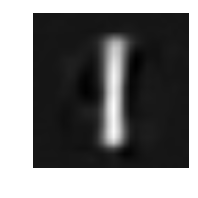

In [52]:
k = np.random.randint(data.shape[0])
showimg(restructed[k])

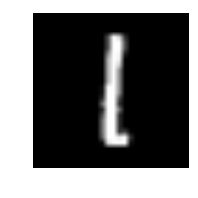

In [53]:
showimg(data[k])

In [13]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('ae-model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    all_vars = tf.get_collection('vars')
    for v in all_vars:
        v_ = sess.run(v)
        print(v_)

[[  2.86834873e-02  -1.39061555e-01   9.90812108e-02 ...,  -7.76194707e-02
    1.04552962e-01  -1.09424941e-01]
 [ -1.44942984e-01  -1.45191833e-01  -1.32203177e-01 ...,   8.48575309e-03
    5.85788302e-02   9.11130309e-02]
 [  4.54552509e-02  -1.41530018e-03   8.69347677e-02 ...,   1.69845104e-01
    8.36464465e-02  -1.11507855e-01]
 ..., 
 [ -6.85491562e-02   7.36519545e-02   9.42029878e-02 ...,  -6.33275211e-02
    1.65143639e-01   1.60737876e-02]
 [  2.35217940e-02  -4.56927530e-02  -4.91639934e-02 ...,   7.45769516e-02
    6.21585138e-02  -1.85274002e-05]
 [ -1.05653275e-02  -6.19795024e-02  -2.53982693e-02 ...,   1.68582853e-02
    1.27419353e-01  -5.43658808e-02]]
[ 0.09998726  0.09999856  0.10001808  0.10000794  0.1000085   0.0999895
  0.10000471  0.0999928   0.09999737  0.10000038  0.09998669  0.10000768
  0.10000328  0.09999685  0.10000204  0.09999375  0.0999746   0.10002139
  0.10000024  0.09999664  0.10001592  0.09998698  0.09999501  0.10000964
  0.09999251  0.09998351  0.1

In [40]:
dataset = DatasetNoLabel(data)

In [65]:
e = ae.decode(ae.encode(data.reshape(-1, 28*28)))

RuntimeError: Attempted to use a closed Session.

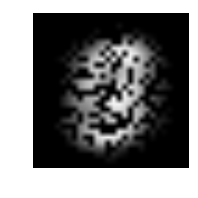

In [63]:
e = e.reshape(-1, 28, 28)
showimg(e[1])

In [64]:
ae.sess_close()